In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import albumentations

import os
import glob

import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageFile

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics

import numpy as np

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [15]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 31.6 MB/s eta 0:00:00


In [16]:
from torchmetrics.functional import char_error_rate

In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
data_path = './samples'
batch_size = 16
image_width = 200
image_height = 50
epochs = 300

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class CaptchaDataset(Dataset):
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        
        self.aug = albumentations.Compose([
            albumentations.Normalize(always_apply=True)
        ])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        targets = self.targets[index]
        
        if self.resize is not None:
            image = image.resize(
                (self.resize[1], self.resize[0]),
                resample=Image.BILINEAR
            )
        
        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            'images': torch.tensor(image, dtype=torch.float),
            'targets': torch.tensor(targets, dtype=torch.long)
        }

In [6]:
class CaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(CaptchaModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3, 3), padding=(1, 1))
        self.max_pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1))
        self.max_pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.linear = nn.Linear(768, 64)
        self.dropout = nn.Dropout(0.2)
        
        self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25)
        self.output = nn.Linear(64, num_chars + 1)

        
    def forward(self, images, targets=None):
        batch_size, chanels, hight, width = images.size()
        
        batch = F.relu(self.conv1(images))
        batch = self.max_pool1(batch)
        batch = F.relu(self.conv2(batch))
        batch = self.max_pool2(batch)
        batch = batch.permute(0, 3, 1, 2)
        batch = batch.view(batch_size, batch.size(1), -1)
        batch = self.linear(batch)
        batch = self.dropout(batch)
        batch, _ = self.gru(batch)
        batch = self.output(batch)
        batch = batch.permute(1, 0, 2)
        
        if targets is not None:
            log_probs = F.log_softmax(batch, 2)
            
            input_lengths = torch.full(
                size=(batch_size, ),
                fill_value=log_probs.size(0),
                dtype=torch.int32
            )
            
            target_lengths = torch.full(
                size=(batch_size, ),
                fill_value=targets.size(1),
                dtype=torch.int32
            )
            
            loss = nn.CTCLoss(blank=0)(
                log_probs, targets, input_lengths, target_lengths
            )
        
        return batch, loss
            

In [8]:
def train_model(model, data_loader, optimizer):
    model.train()
    
    sum_loss = 0
    
    batches = tqdm(data_loader, total=len(data_loader))
    
    for batch in batches:
        for key, value in batch.items():
            batch[key] = value.to(device)
        
        optimizer.zero_grad()
        _, loss = model(**batch)
        
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
    return sum_loss / len(data_loader)

In [9]:
def eval_model(model, data_loader):
    model.eval()
    
    sum_loss = 0
    predictions = []
    
    batches = tqdm(data_loader, total=len(data_loader))
    
    with torch.no_grad():
        for batch in batches:
            for key, value in batch.items():
                batch[key] = value.to(device)

            batch_pred, loss = model(**batch)

            sum_loss += loss.item()
            predictions.append(batch_pred)
        
    return predictions, sum_loss / len(data_loader)

In [84]:
def remove_duplicates(predictions):
    if len(predictions) < 6:
        return predictions
    final_prediction = ""
    for pred in predictions:
        if final_prediction == "":
            final_prediction = pred
        else:
            if pred == final_prediction[-1]:
                continue
            else:
                final_prediction = final_prediction + pred
    return final_prediction

In [101]:
def decode_predictions(preds, encoder, remove_duplicate=True):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for i in range(preds.shape[0]):
        temp = []
        for j in preds[i, :]:
            j = j - 1
            if j == -1:
                temp.append("*")
            else:
                p = encoder.inverse_transform([j])[0]
                temp.append(p)
        tp = "".join(temp).replace("*", "")
        if remove_duplicate:
          tp = remove_duplicates(tp)
        cap_preds.append(tp)
    return cap_preds

In [19]:
image_files = glob.glob(os.path.join(data_path, "*.*"))
targets_orig = [x.split('/')[-1].split('.')[0] for x in image_files]
targets = [[c for c in x] for x in targets_orig]
targets_flat = [c for clist in targets for c in clist]

label_enc = preprocessing.LabelEncoder()
label_enc.fit(targets_flat)
targets_enc = [label_enc.transform(x) for x in targets]
targets_enc = np.array(targets_enc) + 1

(
  train_images, 
  test_images, 
  train_targets, 
  test_targets, 
  train_orig_tergets, 
  test_orig_targets
) = model_selection.train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.1, random_state= 42
)

train_dataset = CaptchaDataset(
    image_paths=train_images,
    targets=train_targets,
    resize=(image_height, image_width)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = CaptchaModel(num_chars=len(label_enc.classes_))
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

for epoch in range(epochs):
    train_loss = train_model(model, train_loader, optimizer)

    if epoch % 10 == 0:
      print(
          f"Epoch={epoch}, Train Loss={train_loss}"
      )
        

100%|██████████| 61/61 [00:01<00:00, 32.73it/s]


Epoch=0, Train Loss=7.045879985465378


100%|██████████| 61/61 [00:02<00:00, 30.31it/s]


Epoch=10, Train Loss=3.269022851693826


100%|██████████| 61/61 [00:01<00:00, 37.65it/s]


Epoch=20, Train Loss=3.2644966234926316


100%|██████████| 61/61 [00:01<00:00, 38.43it/s]


Epoch=30, Train Loss=3.261923942409578


100%|██████████| 61/61 [00:01<00:00, 37.03it/s]


Epoch=40, Train Loss=2.1426880652787257


100%|██████████| 61/61 [00:01<00:00, 37.78it/s]


Epoch=50, Train Loss=0.715848334500047


100%|██████████| 61/61 [00:01<00:00, 37.87it/s]


Epoch=60, Train Loss=0.37343671991199745


100%|██████████| 61/61 [00:02<00:00, 24.47it/s]


Epoch=70, Train Loss=0.22020284147536168


100%|██████████| 61/61 [00:02<00:00, 29.70it/s]


Epoch=80, Train Loss=0.15505877124970077


100%|██████████| 61/61 [00:01<00:00, 36.96it/s]


Epoch=90, Train Loss=0.11641237225200309


100%|██████████| 61/61 [00:01<00:00, 32.85it/s]


Epoch=100, Train Loss=0.10223292846415864


100%|██████████| 61/61 [00:01<00:00, 36.61it/s]


Epoch=110, Train Loss=0.09184300160554588


100%|██████████| 61/61 [00:01<00:00, 37.33it/s]


Epoch=120, Train Loss=0.07371382781716644


100%|██████████| 61/61 [00:01<00:00, 37.40it/s]


Epoch=130, Train Loss=0.05490587134158514


100%|██████████| 61/61 [00:01<00:00, 37.07it/s]


Epoch=140, Train Loss=0.04304428148220797


100%|██████████| 61/61 [00:01<00:00, 32.96it/s]


Epoch=150, Train Loss=0.04884315443942781


100%|██████████| 61/61 [00:01<00:00, 37.11it/s]


Epoch=160, Train Loss=0.03946697189029856


100%|██████████| 61/61 [00:01<00:00, 37.43it/s]


Epoch=170, Train Loss=0.03716089183724195


100%|██████████| 61/61 [00:02<00:00, 28.92it/s]


Epoch=180, Train Loss=0.026893691014742753


100%|██████████| 61/61 [00:01<00:00, 37.68it/s]


Epoch=190, Train Loss=0.015452114132339836


100%|██████████| 61/61 [00:01<00:00, 37.65it/s]


Epoch=200, Train Loss=0.023249787488402646


100%|██████████| 61/61 [00:01<00:00, 31.36it/s]


Epoch=210, Train Loss=0.028076122125580173


100%|██████████| 61/61 [00:01<00:00, 37.56it/s]


Epoch=220, Train Loss=0.01427463865762607


100%|██████████| 61/61 [00:01<00:00, 36.52it/s]


Epoch=230, Train Loss=0.03175566337819471


100%|██████████| 61/61 [00:01<00:00, 37.04it/s]


Epoch=240, Train Loss=0.007525808445071099


100%|██████████| 61/61 [00:01<00:00, 36.21it/s]


Epoch=250, Train Loss=0.02383382017647878


100%|██████████| 61/61 [00:02<00:00, 30.02it/s]


Epoch=260, Train Loss=0.020375700899376917


100%|██████████| 61/61 [00:01<00:00, 36.93it/s]


Epoch=270, Train Loss=0.016513400186296004


100%|██████████| 61/61 [00:01<00:00, 32.85it/s]


Epoch=280, Train Loss=0.010098580683230376


100%|██████████| 61/61 [00:01<00:00, 36.85it/s]


Epoch=290, Train Loss=0.013077736947662578


100%|██████████| 61/61 [00:01<00:00, 36.33it/s]


In [48]:
test_dataset = CaptchaDataset(
    image_paths=test_images,
    targets=test_targets,
    resize=(image_height, image_width)
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [92]:
test_preds, test_loss = eval_model(model, test_loader)
test_captcha_preds = []

for tp in test_preds:
    current_preds = decode_predictions(tp, label_enc)
    test_captcha_preds.extend(current_preds) 

cer = char_error_rate(test_orig_targets, test_captcha_preds)

print(cer.item())

100%|██████████| 107/107 [00:00<00:00, 322.33it/s]

0.060491494834423065


In [104]:
cers = []

for i, pred in enumerate(test_captcha_preds):
  cers.append((i, 
               char_error_rate(pred, test_orig_targets[i]).item(), 
               test_orig_targets[i], 
               pred, 
               decode_predictions(test_preds[i], label_enc, remove_duplicate=False)[0]))

In [111]:
max_cer_indexes = sorted(cers, key=lambda x: x[1], reverse=True)[0:5]
print(max_cer_indexes)

[(86, 0.4000000059604645, 'd7c5x', 'd75xx', 'd75xx'), (3, 0.20000000298023224, 'mc8w2', 'nc8w2', 'nc8w2'), (4, 0.20000000298023224, '32cnn', '32cmn', '32cmn'), (9, 0.20000000298023224, 'e8dxn', 'e8dx', 'e8dx'), (10, 0.20000000298023224, '7b4bm', '7b4bn', '7b44bn')]


CER=0.4000000059604645, true text=d7c5x, predicted text after removing duplicats=d75xx, predicted text before removing duplicats=d75xx


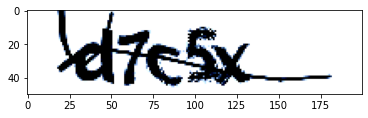

CER=0.20000000298023224, true text=mc8w2, predicted text after removing duplicats=nc8w2, predicted text before removing duplicats=nc8w2


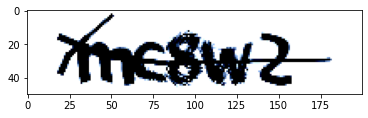

CER=0.20000000298023224, true text=32cnn, predicted text after removing duplicats=32cmn, predicted text before removing duplicats=32cmn


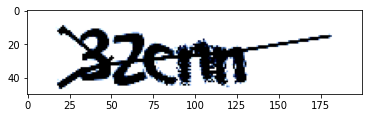

CER=0.20000000298023224, true text=e8dxn, predicted text after removing duplicats=e8dx, predicted text before removing duplicats=e8dx


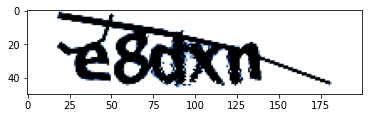

CER=0.20000000298023224, true text=7b4bm, predicted text after removing duplicats=7b4bn, predicted text before removing duplicats=7b44bn


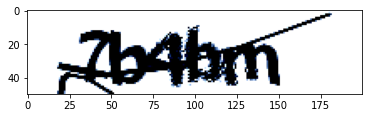

In [112]:
for i in max_cer_indexes:
  print(f'CER={i[1]}, true text={i[2]}, predicted text after removing duplicats={i[3]}, predicted text before removing duplicats={i[4]}')
  img = test_dataset[i[0]]['images']
  plt.imshow(img.permute(1, 2, 0))
  plt.show()

The first picture error can be reasoned by the fact that the model wasn't able to recognise letter c and because of the equality of the string to 5 function remove_duplicates didn't do a propper job. So the prediction ended up to have 2 errors. It can be treated by creating a complicated model, that will better recognise characters.

All other picture's errors are related to the confusion between letters n amd m. We can give our model more examples with this letter to train it better